[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Rozanski_and_Sonntag_1982/figs_4_5_6.ipynb)

single-super-droplet iterative parcel simulation based on [Rozanski & Sonntag 1982](https://doi.org/10.3402/tellusa.v34i2.10795) and extended with:
- oxygen-18 fractionation
- analysis of sensitivity to vertical grid/temperature step (implying the assumed bulk rain sedimentation velocity & isotope relaxation time)

**TODO #1207**:
- rainfall representation?
- Fig. 6
- asserts for T final
- switch to the same fractionation formulae as used in the paper
- move eq. 2 to formulae
- smoke tests

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from open_atmos_jupyter_utils import show_plot
from matplotlib import pyplot, ticker
import numpy as np
from scipy.interpolate import interp1d

from PySDM.physics import si, in_unit
from PySDM import Formulae, Builder, products, dynamics
from PySDM.backends import CPU
from PySDM.environments import Parcel
from PySDM.products.impl import MoistEnvironmentProduct, register_product
from PySDM_examples.utils import BasicSimulation
from PySDM_examples.utils.widgets import FloatProgress, display
from PySDM_examples.Rozanski_and_Sonntag_1982 import MultiBox

In [3]:
FORMULAE = Formulae(
    isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994',
    isotope_meteoric_water_line='Dansgaard1964',
    isotope_ratio_evolution='MerlivatAndJouzel1979',
)
BACKEND = CPU(FORMULAE, override_jit_flags={'parallel': False})
CONST = FORMULAE.constants
TRIVIA = FORMULAE.trivia

FIG4_CAPTION_PARAMS = {
    'T_init': CONST.T0 + 25 * si.K,
    'P_init': 1000 * si.mbar,
    'RH_init': 80 * CONST.PER_CENT,
    # note: R0 in the caption, but negative, hence delta
    'delta_2H_init': -74.7 * CONST.PER_MILLE,
    # the "K" parameter
    'isotope_exchange_factor': 1.,
    # the "N_L" parameter, note: mixing ratio in the caption, but per-volume units, hence density; assuming 1 kg/m3
    'autoconversion_mixrat_threshold': 1 * si.g / si.m**3 / (1 * si.kg / si.m**3)
}

ARBITRARY_PARAMS = {
    'delta_18O_init': FORMULAE.isotope_meteoric_water_line.d18O_of_d2H(
        delta_2H=FIG4_CAPTION_PARAMS['delta_2H_init']
    ),
    'N_SUPER_DROPLETS': 1,
    'Z_RANGE': 7.2 * si.km,
    'N_ITERATIONS': 401,
    'N_PLOT_PROFILES': 10,
}
ARBITRARY_PARAMS['PARCEL_CTOR_ARGS'] = {
    'p0': FIG4_CAPTION_PARAMS['P_init'],
    'initial_water_vapour_mixing_ratio': CONST.eps / (  # TODO #1207: use a physics formula 
        FIG4_CAPTION_PARAMS['P_init']
        / FIG4_CAPTION_PARAMS['RH_init']
        / FORMULAE.saturation_vapour_pressure.pvs_water(FIG4_CAPTION_PARAMS['T_init'])
        - 1
    ),
    'T0': FIG4_CAPTION_PARAMS['T_init'],
    'mass_of_dry_air': 1 * si.kg,
}
ARBITRARY_PARAMS['INIT_ATTRIBUTES'] = Builder(
    n_sd=ARBITRARY_PARAMS['N_SUPER_DROPLETS'],
    backend=BACKEND,
    environment=Parcel(**ARBITRARY_PARAMS['PARCEL_CTOR_ARGS'], dt=np.nan, w=np.nan)
).particulator.environment.init_attributes(
    kappa = 1,
    r_dry = .1 * si.um,
    n_in_dv = (1000 / si.cm**3) * si.m**3,
)

ISOTOPES = ("2H", "18O")

assert (ARBITRARY_PARAMS['N_ITERATIONS'] - 1) % ARBITRARY_PARAMS['N_PLOT_PROFILES'] == 0

In [4]:
@register_product()
class AmbientIsotopicRatio(MoistEnvironmentProduct):
    """ product class for any ambient isotopic ratio """
    def __init__(self, name=None, unit="dimensionless", var=None):
        super().__init__(name=name, unit=unit, var=var)

In [5]:
class Simulation(BasicSimulation):  # pylint:disable=too-few-public-methods
    """ simulation framework mimicking the workflow from R&S 1982 paper """
    def __init__(self, *, isotopes, delta_nl, rain_isotope_ratios, dt, w, nt):
        self.nt = nt
        env = MultiBox(
            **ARBITRARY_PARAMS['PARCEL_CTOR_ARGS'],
            dt=dt,
            w=w,
            delta_nl=delta_nl,
            rain_isotope_ratios=rain_isotope_ratios,
            isotopes=isotopes,
            nt=nt,
            autoconversion_mixrat_threshold=FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'],
            isotope_exchange_factor=FIG4_CAPTION_PARAMS['isotope_exchange_factor'],
        )
        builder = Builder(
            n_sd=ARBITRARY_PARAMS['N_SUPER_DROPLETS'],
            backend=BACKEND,
            environment=env
        )
        builder.add_dynamic(dynamics.AmbientThermodynamics())
        builder.add_dynamic(dynamics.Condensation())

        for isotope in isotopes:
            builder.particulator.environment[f"Rv_{isotope}"][:] = TRIVIA.isotopic_delta_2_ratio(
                delta=(FIG4_CAPTION_PARAMS if isotope == "2H" else ARBITRARY_PARAMS)[f'delta_{isotope}_init'],
                reference_ratio=getattr(CONST, f"VSMOW_R_{isotope}")
            )
        
        super().__init__(particulator = builder.build(
            attributes=ARBITRARY_PARAMS['INIT_ATTRIBUTES'],
            products=(
                products.ParcelDisplacement(name="z"),
                products.AmbientTemperature(var='T', name='T'),
                products.AmbientRelativeHumidity(var='RH', name="RH"),
                products.AmbientWaterVapourMixingRatio(var='water_vapour_mixing_ratio', name='QV'),
                *[
                    AmbientIsotopicRatio(
                        name=f'{ratio}_{isotope}',
                        var=f"{ratio}_{isotope}"
                    ) for isotope in isotopes for ratio in ('Rv', 'Rr')
                ]
            )
        ))

    def run(self):
        retval = self._run(nt=self.nt, steps_per_output_interval=1)
        for k, v in retval.items():
            retval[k] = np.asarray(v)
        retval["QL"] = ARBITRARY_PARAMS['PARCEL_CTOR_ARGS']['initial_water_vapour_mixing_ratio'] - retval['QV']
        return retval

In [6]:
PARAMS = {
    'a': {'timestep': 2*150*si.s, 'updraft': 1*.3 * si.m / si.s},
    'b': {'timestep': 2*150*si.s, 'updraft': 1*.4 * si.m / si.s},
    'c': {'timestep': 2*150*si.s, 'updraft': 1*.5 * si.m / si.s},
    'd': {'timestep': 2*150*si.s, 'updraft': 1*.6 * si.m / si.s},
    'e': {'timestep': 2*150*si.s, 'updraft': 1*.7 * si.m / si.s},
    'f': {'timestep': 2*150*si.s, 'updraft': 1*.8 * si.m / si.s},
}
PARAMS_KEYS = list(PARAMS.keys())

In [7]:
progbar_params = FloatProgress(value=0, min=0, max=100, description='parameters')
progbar_iters = FloatProgress(value=0, min=0, max=100, description='iterations')
display(progbar_params, progbar_iters)

output = {}
for key, params in PARAMS.items():    
    iter_state = {
        'delta_nl': None,
        'rain_isotope_ratios': None
    }
    output[key] = []
    
    for iteration in range(ARBITRARY_PARAMS['N_ITERATIONS']):
        simulation = Simulation(
            delta_nl=iter_state['delta_nl'],
            rain_isotope_ratios=iter_state['rain_isotope_ratios'],
            isotopes=ISOTOPES,
            dt=params['timestep'],
            w=params['updraft'],
            nt=int(ARBITRARY_PARAMS['Z_RANGE'] // (params["updraft"] * params["timestep"]))
        )
        tmp = simulation.run()
        iter_state['rain_isotope_ratios'] = {
            isotope: tmp[f'Rr_{isotope}'] for isotope in ISOTOPES
        }
        if iteration == 0:
            tmp['QR'] = np.maximum(0, tmp['QL'] - FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])
            tmp['QL'] = np.minimum(tmp['QL'], FIG4_CAPTION_PARAMS['autoconversion_mixrat_threshold'])
            tmp['Δz'] = ARBITRARY_PARAMS['Z_RANGE'] / simulation.nt
            iter_state['delta_nl'] = np.diff(np.concatenate(([0], tmp['QR']))) # TODO #1207: per delta-T (which is not constant!!!)
        output[key].append(tmp)
        progbar_iters.value = 100 * (iteration + 1) / ARBITRARY_PARAMS['N_ITERATIONS']
    progbar_params.value = 100 * (PARAMS_KEYS.index(key) + 1) / len(PARAMS_KEYS)

FloatProgress(value=0.0, description='parameters')

FloatProgress(value=0.0, description='iterations')

180.0


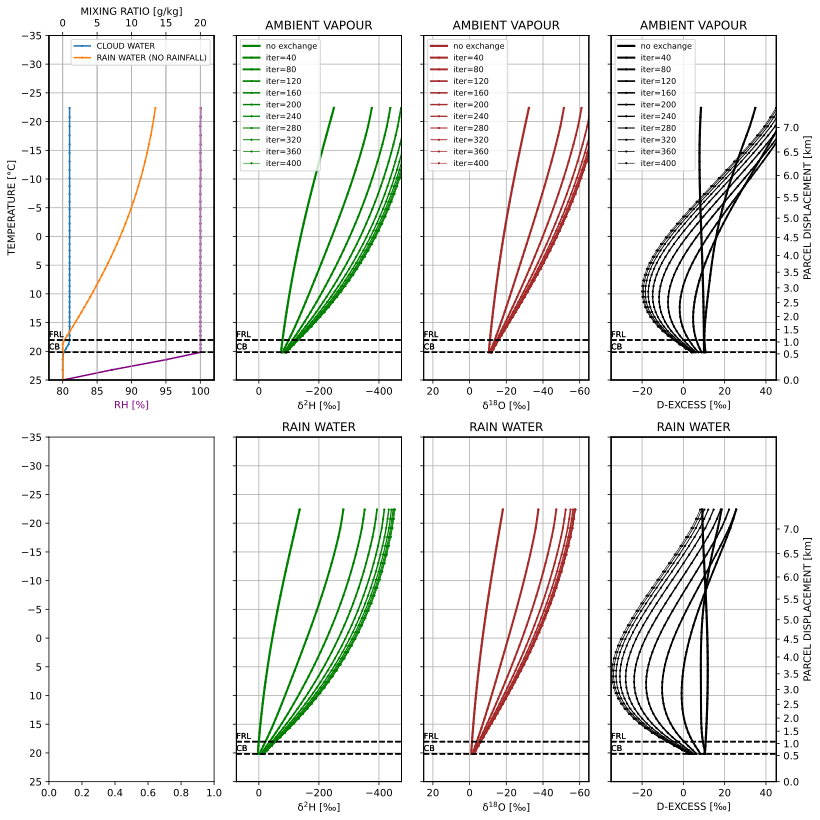

In [8]:
PLOT_KEY = 'd'
print(output[PLOT_KEY][0]['Δz'])

temp_C = output[PLOT_KEY][0]["T"] - CONST.T0
alt_km = in_unit(output[PLOT_KEY][0]["z"], si.km) 

fig, axs = pyplot.subplots(2, 4, squeeze=False, sharey=True, figsize=(11.5, 11.5), tight_layout=True)

plot_kwargs = {
    'markersize': 2.5,
    'marker': '.'
}

axs[0,0].set_ylabel('TEMPERATURE [°C]')
axs[0,0].set_ylim(25, -35)
axs[0,0].yaxis.set_major_locator(ticker.MultipleLocator(5))

axs[0,0].plot(
    output[PLOT_KEY][0]['RH'] / CONST.PER_CENT,
    temp_C,
    color='purple',
    label='RH',
    **plot_kwargs
)
axs[0,0].set_xlabel('RH [%]', color='purple')
axs[0,0].set_xlim(80-2, 100+2)
axs[0,0].grid()

twin = axs[0,0].twiny()
twin.plot(
    in_unit(output[PLOT_KEY][0]['QL'], si.g / si.kg),
    temp_C,
    label='CLOUD WATER',
    **plot_kwargs
)
twin.plot(
    in_unit(output[PLOT_KEY][0]['QR'], si.g / si.kg),
    temp_C,
    label='RAIN WATER (NO RAINFALL)',
    **plot_kwargs,
)
twin.set_xlabel('MIXING RATIO [g/kg]')
twin.set_xlim(-2, 20+2)
twin.grid()
twin.legend(fontsize=8)

level_indices = {
    'CB': np.argmin(output[PLOT_KEY][0]['RH'] < 1),
    'FRL': np.amin(np.argmax(output[PLOT_KEY][0]['QL'])),
}
for plot_row, ratio, title in ((0, "Rv", "AMBIENT VAPOUR"), (1, "Rr", "RAIN WATER")):
    for iteration in range(
        0,
        ARBITRARY_PARAMS['N_ITERATIONS'],
        (ARBITRARY_PARAMS['N_ITERATIONS']-1) // ARBITRARY_PARAMS['N_PLOT_PROFILES']
    ):
        deltas = {
            iso: TRIVIA.isotopic_ratio_2_delta(
                ratio=output[PLOT_KEY][iteration][f'{ratio}_{iso}'][level_indices['CB']:],
                reference_ratio=getattr(CONST, f"VSMOW_R_{iso}")
            ) for iso in ISOTOPES
        }
    
        iter_kwargs = {
            'linewidth': 2.2 - 1.6 * iteration / ARBITRARY_PARAMS['N_ITERATIONS'],
            'label': ('no exchange' if iteration == 0 else f"iter={iteration}"),
            **plot_kwargs
        }
        
        for ax, iso, color in ((axs[plot_row, 1], '2H', 'green'), (axs[plot_row, 2], "18O", 'brown')):
            ax.set_title(title)
            ax.plot(
                in_unit(deltas[iso], CONST.PER_MILLE),
                temp_C[level_indices['CB']:],
                color=color,
                **iter_kwargs
            )
        axs[plot_row, 3].plot(
            in_unit(
                FORMULAE.isotope_meteoric_water_line.excess_d(delta_2H=deltas["2H"], delta_18O=deltas["18O"]),
                CONST.PER_MILLE
            ),
            temp_C[level_indices['CB']:],
            color='black',
            **iter_kwargs
        )
        axs[plot_row, 3].set_title(title)
    
    axs[plot_row, 1].set_xlabel('δ$^{2}$H [‰]')
    axs[plot_row, 1].set_xlim(75, -475)
    axs[plot_row, 1].grid()
    
    axs[plot_row, 2].set_xlabel('δ$^{18}$O [‰]')
    axs[plot_row, 2].set_xlim(25, -65)
    axs[plot_row, 2].grid()
    
    if plot_row == 0:
        axs[plot_row, 1].legend(loc="upper left", fontsize=8)
        axs[plot_row, 2].legend(loc="upper left", fontsize=8)
        axs[plot_row, 3].legend(loc="upper left", fontsize=8)
    
    axs[plot_row, 3].grid()
    axs[plot_row, 3].set_xlim(-35, 45)
    axs[plot_row, 3].set_xlabel("D-EXCESS [‰]")
    twin = axs[plot_row, 3].twinx()
    twin.set_ylabel('PARCEL DISPLACEMENT [km]')
    twin.set_ylim(axs[plot_row, 2].get_ylim())
    twin.set_yticks(*[(interp1d(alt_km, temp_C)(ticks_km), ticks_km) for ticks_km in (np.linspace(0, 7, 15),)][0])

    for i, ax in enumerate(axs.flatten()):
        if i == 4:
            continue
        twinx = ax.twiny()
        twinx.set_xlim(0, 1)
        twinx.set_xticks([])
        for label, level_index in level_indices.items():
            twinx.plot([0, 1], [temp_C[level_index]]*2, color='black', linestyle='--')
            twinx.text(0, temp_C[level_index] - .5, label, fontsize=8)

show_plot('fig_4.pdf')

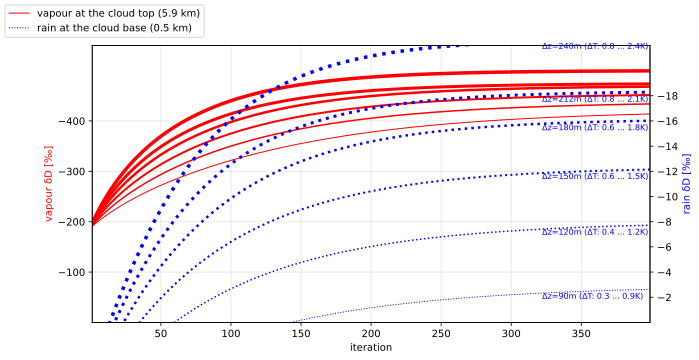

In [9]:
fig = pyplot.figure(figsize=(10,5))
axs = fig.gca()
twinx = pyplot.gca().twinx()
lines = []
data = {}
for key in PARAMS:
    levels = {
        'CB': .5 * si.km,
        'CT': 5.9 * si.km,
    }
    data[key] = {
        lev_key: {
            k: np.asarray([
                interp1d(output[key][i]['z'], output[key][i][k])(lev_alt)
                for i in range(ARBITRARY_PARAMS['N_ITERATIONS'])
            ])
            for k in ('Rv_2H', 'Rr_2H')
        }
        for lev_key, lev_alt in levels.items()
    }

    delta_T = np.abs(np.diff(output[key][0]['T']))
    label = f"Δz={output[key][0]['Δz']:.0f}m (ΔT: {min(delta_T):.1f} ... {max(delta_T):.1f}K)"
    
    colors = {'vapour': 'red', 'rain': 'blue'}
    linewidth = 1 + .5 * PARAMS_KEYS.index(key)
    line_v = axs.plot(
        in_unit(TRIVIA.isotopic_ratio_2_delta(
            ratio=data[key]['CT']["Rv_2H"][1:],
            reference_ratio=CONST.VSMOW_R_2H
        ), CONST.PER_MILLE),
        label=f"vapour at the cloud top ({in_unit(levels['CT'], si.km)} km)",
        color=colors['vapour'],
        linewidth=linewidth
    )

    rain_data = in_unit(TRIVIA.isotopic_ratio_2_delta(
        ratio=data[key]['CB']["Rr_2H"][1:],
        reference_ratio=CONST.VSMOW_R_2H
    ), CONST.PER_MILLE)
    line_r = twinx.plot(
        rain_data,
        label=f"rain at the cloud base ({in_unit(levels['CB'], si.km)} km)",
        color=colors['rain'],
        linestyle=':',
        linewidth=linewidth
    )

    twinx.annotate(label, (322, rain_data[-1]+.75), color='blue', size=8)
    
    if PARAMS_KEYS.index(key) == 0:
        lines += [*line_v, *line_r]
twinx.set_ylabel('rain δD [‰]', color=colors['rain'])
axs.set_ylabel('vapour δD [‰]', color=colors['vapour'])
axs.set_xlim(1, ARBITRARY_PARAMS['N_ITERATIONS']-2)
axs.set_xlabel('iteration')
axs.grid(alpha=.333)
fig.legend(lines, [l.get_label() for l in lines], loc='upper left')

twinx.set_ylim(0, -22)
twinx.set_yticks(np.linspace(-2, -18, 9))
axs.set_yticks(np.linspace(-100, -400, 4))
axs.set_ylim(0, -550)

show_plot('fig_5.pdf')